In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../python')
import plot_info
import json
from IPython.core.display import display, HTML
import copy
import pprint
import re

In [2]:
basename='../data/airfoils_qmc_{}.json'

In [3]:
def fix_bilevel(configuration):
    """
    In an earlier verison (4f65635f5b32b842b8b5c80f9978520c85545b25) there was an error in how
    the error (yes) of bilevel was calculated. This fixes this, and adds relative errors
    """
    
    for config in configuration['configurations']:
        sources = [config['results']['best_network']['algorithms']]
        sources.extend([config['results']['retrainings'][k]['algorithms'] for k in config['results']['retrainings'].keys()])
        basemean = config['results']['best_network']['reference_sampling_error']['mean']
        basevar = config['results']['best_network']['reference_sampling_error']['var']
        
        basemeanmlmc = config['results']['best_network']['base_sampling_error']['mean_bilevel']
        basevarmlmc = config['results']['best_network']['base_sampling_error']['var_bilevel']
        
        config['results']['best_network']['base_sampling_error']['mean_bilevel_error'] = abs(basemean-basemeanmlmc)
        config['results']['best_network']['base_sampling_error']['mean_bilevel_error_relative'] = abs(basemean-basemeanmlmc)/abs(basemean)
        
        config['results']['best_network']['base_sampling_error']['var_bilevel_error'] = abs(basevar-basevarmlmc)
        config['results']['best_network']['base_sampling_error']['var_bilevel_error_relative'] = abs(basevar-basevarmlmc)/abs(basevar)
        
        
        for source in sources:
            for algorithm in source.keys():
                for fit in source[algorithm].keys():
                    for tactic in source[algorithm][fit].keys():
                      
                        
                        mlmc_mean = source[algorithm][fit][tactic]['mean_bilevel']
                        source[algorithm][fit][tactic]['mean_bilevel_error'] = \
                            abs(mlmc_mean-basemean)
                        source[algorithm][fit][tactic]['mean_bilevel_error_relative'] = \
                            abs(mlmc_mean-basevar)/abs(basemean)
                        
                        
                        mlmc_var = config['results']['best_network']['algorithms'][algorithm][fit][tactic]['var_bilevel']
                        source[algorithm][fit][tactic]['var_bilevel_error'] = \
                            abs(mlmc_var-basevar)
                        source[algorithm][fit][tactic]['var_bilevel_error_relative'] = \
                            abs(mlmc_var-basevar)/abs(basevar)
                        
                
def add_wasserstein_speedup(configuration, convergence_rate):
    """
    Adds the wasserstein speedup to the data. 
    """
        
    for config in configuration['configurations']:
        sources = [config['results']['best_network']['algorithms']]
        sources.extend([config['results']['retrainings'][k]['algorithms'] for k in config['results']['retrainings'].keys()])
        
        # Speedup is always one when we compare to ourself:
        config['results']['best_network']['base_sampling_error']['wasserstein_speedup'] = 1
        
        #####
        for source in sources:
            for algorithm in source.keys():
                for fit in source[algorithm].keys():
                    
                    for tactic in source[algorithm][fit].keys():
                        base = config['results']['best_network']['reference_sampling_error']['wasserstein_error_cut']
                        wasserstein = source[algorithm][fit][tactic]['wasserstein_error_cut']
                        source[algorithm][fit][tactic]['wasserstein_speedup_raw'] = base/wasserstein
                        
                        source[algorithm][fit][tactic]['wasserstein_speedup_real'] = (base/wasserstein)**(1.0/convergence_rate)
                    
            
                    
                    
                
                
            

In [4]:
functionals = ['Drag', 'Lift']

data = {}
convergence_rate =0.75
for functional in functionals:
    data[functional] = []
    
    filename = basename.format(functional.lower())
    
    with open(filename, 'r') as f:
        json_content = json.load(f)
        fix_bilevel(json_content)
        add_wasserstein_speedup(json_content, convergence_rate)
        data[functional] = copy.deepcopy(json_content)

In [5]:
class LatexWithAllPlots(object):
    def __init__(self):
        self.text = """
\\documentclass[a4paper]{article}
"""
        with open('../latex/header.tex') as header:
            self.text += header.read()
        self.text += """
\\begin{document}
\\tableofcontents
\\clearpage 
        """
    def __call__(self, image_path, basename, title):
        self.text += \
        """
%%%%%%%%%%%%%
% {full_path}
\\begin{{figure}}
\\InputImage{{0.8\\textwidth}}{{0.6\\textheight}}{{{image_name}}}
\\cprotect\\caption{{{title}\\\\
\\textbf{{To include:}}\\\\ \\verb|\\InputImage{{0.8\\textwidth}}{{0.6\\textheight}}{{{image_name}}}|\\\\
Full path:\\
(\\verb|{full_path}|)
}}

\\end{{figure}}
""".format(image_name=basename, full_path=image_path, title=title)
        
    def get_latex(self):
        return self.text + "\n\\end{document}"
    
        
textLatex = LatexWithAllPlots()
textLatex('full/path_to/imageName.png', 'imageName_with_something', 'a very very long title')
print(textLatex.get_latex())


\documentclass[a4paper]{article}
\usepackage{caption}
\usepackage{subcaption}
\usepackage{pgfplots}
\usepgfplotslibrary{groupplots}
\usepackage{amsmath,amssymb,amsfonts, amsthm}
\usepackage{nicefrac}
\usepackage{cprotect}
\newlength\figureheight
\newlength\figurewidth
\usepackage{etoolbox}
\usepackage{graphicx}

\newtoggle{usetikz}
\togglefalse{usetikz}
\newcommand{\InputImage}[3]{}
\iftoggle{usetikz}{%
	\renewcommand{\InputImage}[3]{%
		\setlength\figureheight{#2}%
		\setlength\figurewidth{#1}%
		\input{img_tikz/#3.tikz}%
	}%
} { %
	\renewcommand{\InputImage}[3]{%
		
		\includegraphics[width=#1]{img_downscaled/#3}%
	}%
}


%\usepgfplotslibrary{external} 
%\tikzexternalize






\begin{document}
\tableofcontents
\clearpage 
        
%%%%%%%%%%%%%
% full/path_to/imageName.png
\begin{figure}
\InputImage{0.8\textwidth}{0.6\textheight}{imageName_with_something}
\cprotect\caption{a very very long title\\
\textbf{To include:}\\ \verb|\InputImage{0.8\textwidth}{0.6\textheight}{imageName_with

In [6]:
def get_dict_path(dictionary, path):
    split = path.split('.')
    for s in split:
        dictionary = dictionary[s]
    return dictionary

# As a function of training size
def plot_as_training_size(functional, data, title="all configurations"):
    train_sizes = []
    
    for configuration in data['configurations']:
        train_size = int(configuration['settings']['train_size'])
        if train_size not in train_sizes:
            train_sizes.append(train_size)
    print(train_sizes) 
    train_sizes = sorted(train_sizes)
    
    data_source_names = data['configurations'][0]['results']['best_network']['algorithms'].keys()
    for k in data_source_names:
        if re.match(r'^[Q]?MC_from_data$', k):
            data_source = k
            break
            
    sampling_method = re.search(r'(^[Q]?MC)_from_data$', data_source).group(1)
    names = {
        "mean_error_relative" : "relative error for mean",
        "var_error_relative" : "relative error for variance",
        "wasserstein_error_cut" : "Wasserstein",
        "mean_bilevel_error_relative": "relative error bilevel mean",
        "var_bilevel_error_relative" :"relative error bilevel variance",
        "prediction_l1_relative": 'relative prediction error ($L^1$)',
        "prediction_l2_relative" : 'relative prediction error ($L^2$)',
        'wasserstein_speedup_raw' : 'Raw Wasserstein speedup',
        'wasserstein_speedup_real' : 'Wasserstein speedup with convergence rate',
    }
    
    competitor_keys = {
        "mean_error_relative" : "results.best_network.base_sampling_error.mean_error_relative",
        "var_error_relative" : "results.best_network.base_sampling_error.mean_error_relative",
        "wasserstein_error_cut" : "results.best_network.base_sampling_error.wasserstein_error_cut",
        "mean_bilevel_error_relative": "results.best_network.base_sampling_error.mean_error",
        "var_bilevel_error_relative" :"results.best_network.base_sampling_error.var_error",
        "prediction_l1_relative": 'results.best_network.algorithms.{data_source}.lsq.ordinary.prediction_l1_relative'.format(data_source=data_source),
        "prediction_l2_relative" :  'results.best_network.algorithms.{data_source}.lsq.ordinary.prediction_l2_relative'.format(data_source=data_source),
        'wasserstein_speedup_raw' : "results.best_network.base_sampling_error.wasserstein_speedup",
        'wasserstein_speedup_real' : "results.best_network.base_sampling_error.wasserstein_speedup",
    }
    
    competitor_names = {
        "mean_error_relative" : sampling_method,
        "var_error_relative" : sampling_method,
        "wasserstein_error_cut" : sampling_method,
        "mean_bilevel_error_relative": sampling_method,
        "var_bilevel_error_relative" : sampling_method,
        "prediction_l1_relative": 'LSQ (with {})'.format(sampling_method),
        "prediction_l2_relative" : 'LSQ (with {})'.format(sampling_method),
         'wasserstein_speedup_raw' : sampling_method,
        'wasserstein_speedup_real' : sampling_method
    }
    
    errors = {
    }
    
    
    
    errors_var = {}
    errors_min = {}
    
    errors_max = {}
    
    errors_retraining = {}
    errors_retraining_var = {}
    errors_min = {}
    
    errors_max = {}
    competitor = {}
    for k in names.keys():
        errors[k] = np.zeros(len(train_sizes))
        errors_var[k]  = np.zeros(len(train_sizes))
        errors_max[k]  = np.zeros(len(train_sizes))
        errors_min[k]  = np.zeros(len(train_sizes))
        errors_retraining[k]  = np.zeros(len(train_sizes))
        errors_retraining_var[k]  = np.zeros(len(train_sizes))
        competitor[k]  = np.zeros(len(train_sizes))
        
    
    for error in errors.keys():
        tactics=['ordinary', 'add', 'remove', 'replace']
        for t, tactic in enumerate(tactics):
            for (n, train_size) in enumerate(train_sizes):
                errors_local = []
                for configuration in data['configurations']:
                    ts = int(configuration['settings']['train_size'])
                    if ts == train_size:
                        errors_local.append(configuration['results']['best_network']['algorithms'][data_source]['ml'][tactic][error])
                        competitor[error][n] = get_dict_path(configuration, competitor_keys[error])
                        
                
                            
                errors[error][n] = np.mean(errors_local)
                errors_var[error][n] = np.var(errors_local)
                errors_min[error][n] = np.amin(errors_local)
                errors_max[error][n] = np.amax(errors_local)
                
                
                
                errors_local = []
                for configuration in data['configurations']:
                    ts = int(configuration['settings']['train_size'])
                    if ts == train_size:
                        retrainings = configuration['results']['retrainings'].keys()
                        for retraining in retrainings:
                            errors_local.append(configuration['results']['retrainings'][retraining]['algorithms'][data_source]['ml'][tactic][error])
                errors_retraining[error][n] = np.mean(errors_local)
                errors_retraining_var[error][n] = np.var(errors_local)
                
                
                
            plt.figure(0)
            
            
            p = plt.errorbar(train_sizes, errors[error], yerr=np.sqrt(errors_var[error]), label=tactic,
                            solid_capstyle='projecting', capsize=5)
            plt.figure(t+1)
            plt.errorbar(train_sizes, errors[error], yerr=np.sqrt(errors_var[error]),
                            solid_capstyle='projecting', capsize=5, label='Machine learning')
            
            
            plt.figure(len(tactics)+1)
            p = plt.errorbar(train_sizes, errors_retraining[error], yerr=np.sqrt(errors_retraining_var[error]), label=tactic,
                            solid_capstyle='projecting', capsize=5)
            
            plt.figure(len(tactics)+1+t+1)
            plt.errorbar(train_sizes, errors_retraining[error], yerr=np.sqrt(errors_retraining_var[error]),
                            solid_capstyle='projecting', capsize=5, label='Machine learning')
            
            
            
            plt.figure(2*(len(tactics)+1))
            p = plt.errorbar(train_sizes, errors[error], yerr=np.sqrt(errors_var[error]), \
                             label='Selected retraining ({})'.format(tactic), ls='--',
                            solid_capstyle='projecting', capsize=5)
            
            p = plt.errorbar(train_sizes, errors_retraining[error], 
                             yerr=np.sqrt(errors_retraining_var[error]), 
                             label='Average of retraining ({})'.format(tactic),
                            solid_capstyle='projecting', capsize=10)
            
            
            
            plt.figure(2*(len(tactics)+1)+t+1)
            p = plt.errorbar(train_sizes, errors[error], yerr=np.sqrt(errors_var[error]), \
                             label='Selected retraining', ls='--',
                            solid_capstyle='projecting', capsize=5)
            
            p = plt.errorbar(train_sizes, errors_retraining[error], 
                             yerr=np.sqrt(errors_retraining_var[error]), 
                             label='Average of retraining', 
                            solid_capstyle='projecting', capsize=10)

            
            #plt.loglog(train_sizes, errors_min[error], '.--', label='{} minimum'.format(tactic), color=p[0].get_color())
            #plt.loglog(train_sizes, errors_max[error], '--', label='{} maximum'.format(tactic), color=p[0].get_color())
        plt.figure(0)
        
        plt.gca().set_xscale("log", nonposx='clip', basex=2)
        plt.gca().set_yscale("log", nonposy='clip', basey=2)
        plt.title('Average {}\nConfigurations: {}\nfor {}'.format(names[error], title, functional))
        plt.xlabel("Training size")
        plt.ylabel(names[error])
        plt.grid(True)
        #plt.ylim([max(min(errors[error]-np.sqrt(errors_var[error])),0), max(errors[error]+np.sqrt(errors_var[error]))])
        plot_info.savePlot('combined_{functional}_{error}_{title}_convergence_training_size'.format(functional=functional,
                                                                                      error=error, title=title))
        
        
        
        plt.loglog(train_sizes, competitor[error], '--o', label=competitor_names[error], basex=2, basey=2)
        plot_info.legendLeft()
        plot_info.savePlot('combined_with_compare_{functional}_{error}_{title}_convergence_training_size'.format(functional=functional,
                                                                                      error=error, title=title))
        
        
        plt.figure(len(tactics)+1)
        
        plt.gca().set_xscale("log", nonposx='clip', basex=2)
        plt.gca().set_yscale("log", nonposy='clip', basey=2)
        plt.title('Average (with retraining variance) {}\nConfigurations: {}\nfor {}'.format(names[error], title, functional))
        plt.xlabel("Training size")
        plt.ylabel(names[error])
        plt.grid(True)
        #plt.ylim([max(min(errors[error]-np.sqrt(errors_var[error])),0), max(errors[error]+np.sqrt(errors_var[error]))])
        plot_info.savePlot('combined_retraining_{functional}_{error}_{title}_convergence_training_size'.format(functional=functional,
                                                                                      error=error, title=title))
        
        
        
        plt.loglog(train_sizes, competitor[error], '--o', label=competitor_names[error], basex=2, basey=2)
        plot_info.legendLeft()
        plot_info.savePlot('combined_retraining_with_compare_{functional}_{error}_{title}_convergence_training_size'.format(functional=functional,
                                                                                      error=error, title=title))
        
        
        
        
        
        
        
        
        plt.figure(2*(len(tactics)+1))
        
        plt.gca().set_xscale("log", nonposx='clip', basex=2)
        plt.gca().set_yscale("log", nonposy='clip', basey=2)
        plt.title('Average (with retraining variance) {}\nConfigurations: {}\nfor {}'.format(names[error], title, functional))
        plt.xlabel("Training size")
        plt.ylabel(names[error])
        plt.grid(True)
        #plt.ylim([max(min(errors[error]-np.sqrt(errors_var[error])),0), max(errors[error]+np.sqrt(errors_var[error]))])
        plot_info.savePlot('combined_retraining_best_{functional}_{error}_{title}_convergence_training_size'.format(functional=functional,
                                                                                      error=error, title=title))
        
        
        
        plt.loglog(train_sizes, competitor[error], '--o', label=competitor_names[error], basex=2, basey=2)
        plot_info.legendLeft()
        plot_info.savePlot('combined_retraining_best_with_compare_{functional}_{error}_{title}_convergence_training_size'.format(functional=functional,
                                                                                      error=error, title=title))
        
        
        
        for t, tactic in enumerate(tactics):
            plt.figure(t+1)
            plot_info.legendLeft()
            plt.gca().set_xscale("log", nonposx='clip', basex=2)
            plt.gca().set_yscale("log", nonposy='clip', basey=2)
            plt.title('Average {}\nConfigurations: {}\n for {}\n(Using "{tactic}" to deal with training samples)'.format(names[error], title, functional,
                                                                                                          tactic=tactic))
            plt.xlabel("Training size")
            plt.ylabel(names[error])
            plt.grid(True)
            #plt.ylim([max(min(errors[error]-np.sqrt(errors_var[error])),0), max(errors[error]+np.sqrt(errors_var[error]))])
            plot_info.savePlot('combined_{functional}_{error}_{title}_{tactic}_convergence_training_size'.format(functional=functional,
                                                                                              error=error, title=title,
                                                                                                                   tactic=tactic))
            
            plt.loglog(train_sizes, competitor[error], '--o', label=competitor_names[error], basex=2, basey=2)
            plot_info.legendLeft()
            plot_info.savePlot('combined_with_compare_{functional}_{error}_{title}_{tactic}_convergence_training_size'.format(functional=functional,
                                                                                              error=error, title=title,
                                                                                                                   tactic=tactic))
            plt.close(t+1)
            
            
            plt.figure(len(tactics)+1+t+1)
            plot_info.legendLeft()
            plt.gca().set_xscale("log", nonposx='clip', basex=2)
            plt.gca().set_yscale("log", nonposy='clip', basey=2)
            plt.title('Average (with retraining) {}\nConfigurations: {}\n for {}\n(Using "{tactic}" to deal with training samples)'.format(names[error], title, functional,
                                                                                                          tactic=tactic))
            plt.xlabel("Training size")
            plt.ylabel(names[error])
            plt.grid(True)
            #plt.ylim([max(min(errors[error]-np.sqrt(errors_var[error])),0), max(errors[error]+np.sqrt(errors_var[error]))])
            plot_info.savePlot('combined_retraining_{functional}_{error}_{title}_{tactic}_convergence_training_size'.format(functional=functional,
                                                                                              error=error, title=title,
                                                                                                                   tactic=tactic))
            
            plt.loglog(train_sizes, competitor[error], '--o', label=competitor_names[error], basex=2, basey=2)
            plot_info.legendLeft()
            plot_info.savePlot('combined_retraining_with_compare_{functional}_{error}_{title}_{tactic}_convergence_training_size'.format(functional=functional,
                                                                                              error=error, title=title,
                                                                                                                   tactic=tactic))
            
            plt.close(len(tactics)+1+t+1)
            
            
            
            
            
            plt.figure(2*(len(tactics)+1)+t+1)
            plot_info.legendLeft()
            plt.gca().set_xscale("log", nonposx='clip', basex=2)
            plt.gca().set_yscale("log", nonposy='clip', basey=2)
            plt.title('Average (with retraining) {}\nConfigurations: {}\n for {}\n(Using "{tactic}" to deal with training samples)'.format(names[error], title, functional,
                                                                                                          tactic=tactic))
            plt.xlabel("Training size")
            plot_info.legendLeft()
            plt.ylabel(names[error])
            plt.grid(True)
            #plt.ylim([max(min(errors[error]-np.sqrt(errors_var[error])),0), max(errors[error]+np.sqrt(errors_var[error]))])
            plot_info.savePlot('combined_retraining_best_{functional}_{error}_{title}_{tactic}_convergence_training_size'.format(functional=functional,
                                                                                              error=error, title=title,
                                                                                                                   tactic=tactic))
            
            plt.loglog(train_sizes, competitor[error], '--o', label=competitor_names[error], basex=2, basey=2)
            plot_info.legendLeft()
            plot_info.savePlot('combined_retraining_best_with_compare_{functional}_{error}_{title}_{tactic}_convergence_training_size'.format(functional=functional,
                                                                                              error=error, title=title,
                                                                                                                   tactic=tactic))
            
            plt.close(2*(len(tactics)+1)+t+1)
        plt.show()

In [7]:
def filter_configs(data, excludes={}, onlys={}, test_functions = []):
    data_copy = {}
    
    for k in data.keys():
        if k != 'configurations':
            data_copy[k] = copy.deepcopy(data[k])
    data_copy['configurations'] = []
    print(len(data['configurations']))
    for config in data['configurations']:
        keep = True
        for exclude_path in excludes.keys():
            split = exclude[0].split('.')
            value = config
            for k in split:
                value = value[k]
            excluded_values = excludes[exclude_path]
            
            for excluded_value in excluded_values:
                if value == excluded_value:
                    keep = False
        if not keep:
            continue
            
        for only_path in onlys.keys():
            split = only_path[0].split('.')
            value = config
            for k in split:
                value = value[k]
            only_values = onlys[only_path]
            
            equal_to_one = False
            for only_value in only_values:
                if value == only_value:
                    equal_to_one = True
            if not equal_to_one:
                keep = False
        
        if not keep:
            continue
        
        
        for test_function in test_functions:
            if not test_function(config):
                keep = False
                
        if not keep:
            continue
        
            
        data_copy['configurations'].append(copy.deepcopy(config))
    print(len(data_copy['configurations']))
    return data_copy

In [8]:
onlys = {
    "" : {},
    "Best performing": {"settings.selection_type":"Best performing"},
    "Emperically optimal" :{"settings.selection_type":"Emperically optimal"},
}

def has_regularization(config):
    return config['settings']['regularizer'] is not None and config['settings']['regularizer'] != "None"

def get_regularization(config):
    return config['settings']['regularizer']
def get_optimizer(config):
    return config['settings']['optimizer']

def get_loss(config):
    return config['settings']['loss']

def only_adam_and_no_regularization_for_mse(config):
    return get_optimizer(config) == 'Adam' and (get_loss(config) == 'mean_absolute_error' or not has_regularization(config))

def only_adam_and_no_regularization_for_mse_and_reg_for_l1(config):
    if get_optimizer(config) != 'Adam':
        return False
    if get_loss(config) == 'mean_absolute_error':
        return has_regularization(config)
    else:
        return not has_regularization(config)
    
def best_configuration_1(config):
    """Adam, mean_absolute_error, ray_prediction, l2 reg"""
    if get_optimizer(config) != 'Adam':
        return False
    
    if get_loss(config) != 'mean_absolute_error':
        return False
    
    if get_selection(config) != 'ray_prediction':
        return False
    
    if not has_regularization(config):
        return False
    
    return get_regularization(config)['l2'] > 0 and get_regularization(config)['l1'] == 0

def best_configuration_2(config):
    """Adam, mean_squared_error, train, No reg"""
    if get_optimizer(config) != 'Adam':
        return False
    
    if get_loss(config) != 'mean_squared_error':
        return False
    
    if get_selection(config) != 'train':
        return False
    
    return not has_regularization(config)


def best_configuration_3(config):
    """Adam, mean_absolute_error, wasserstein_train, l2 reg"""
    if get_optimizer(config) != 'Adam':
        return False
    
    if get_loss(config) != 'mean_absolute_error':
        return False
    
    if get_selection(config) != 'wasserstein_train':
        return False
    
    if not has_regularization(config):
        return False
    
    return get_regularization(config)['l2'] > 0 and get_regularization(config)['l1'] == 0


def best_configuration_4(config):
    """Adam, mean_absolute_error, ray_prediction, l1 reg"""
    if get_optimizer(config) != 'Adam':
        return False
    
    if get_loss(config) != 'mean_absolute_error':
        return False
    
    if get_selection(config) != 'ray_prediction':
        return False
    
    if not has_regularization(config):
        return False
    
    return get_regularization(config)['l1'] > 0 and get_regularization(config)['l2'] == 0


In [9]:
filters = {
    'All configurations' : lambda x: True,
    'Only Adam with ($L^2$ and no regularization) or ($L^1$)' : only_adam_and_no_regularization_for_mse,
    'Only Adam with ($L^2$ and no regularization) or ($L^1$ with regularization)' : only_adam_and_no_regularization_for_mse_and_reg_for_l1,
}

for f in [best_configuration_1, best_configuration_2, best_configuration_3, best_configuration_4]:
    filters[f.__doc__] = f

    

1015
1015
[64, 128, 256, 32]


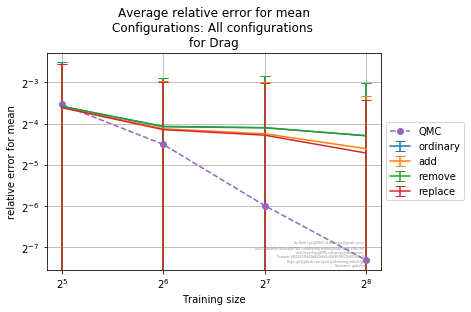

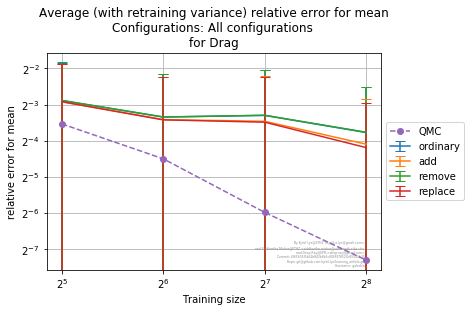

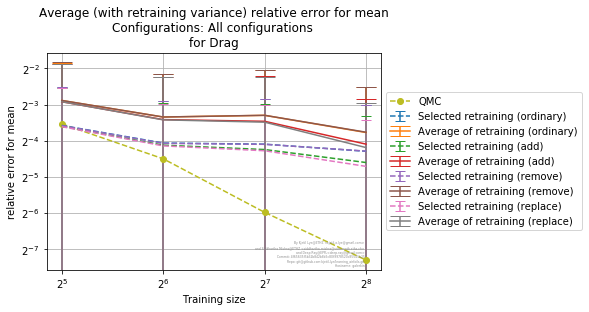

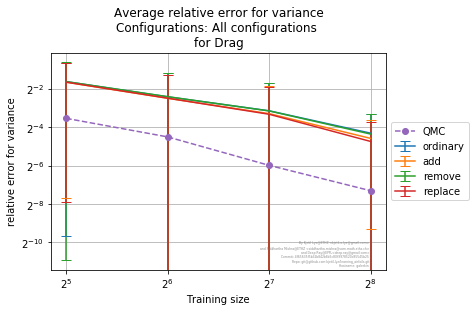

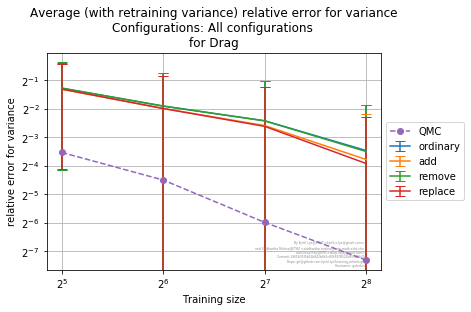

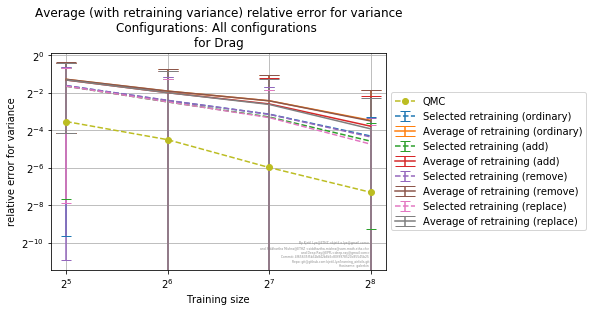

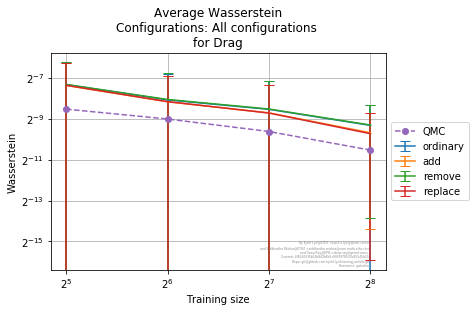

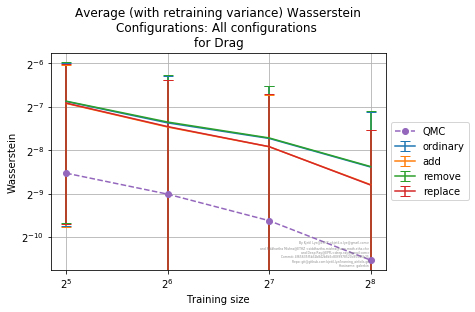

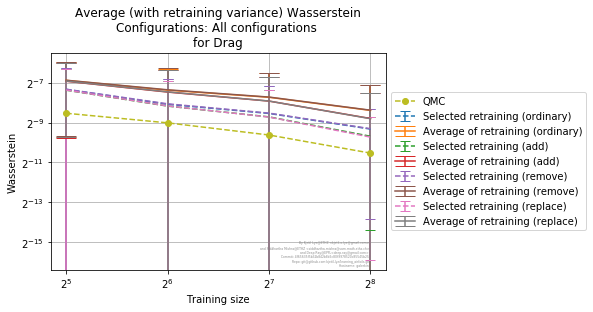

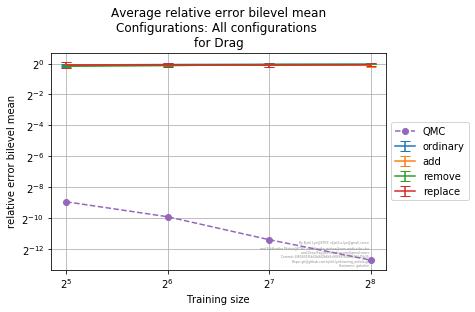

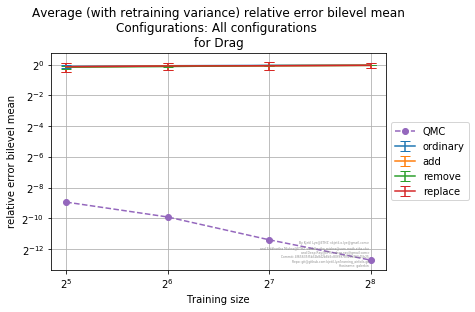

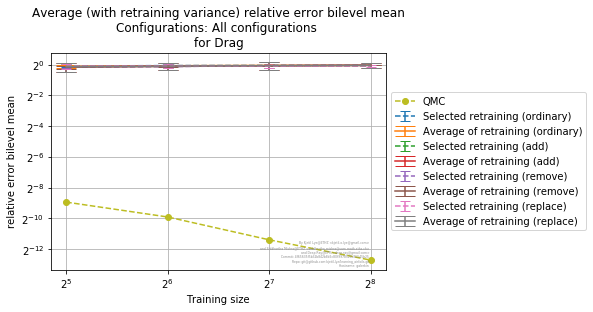

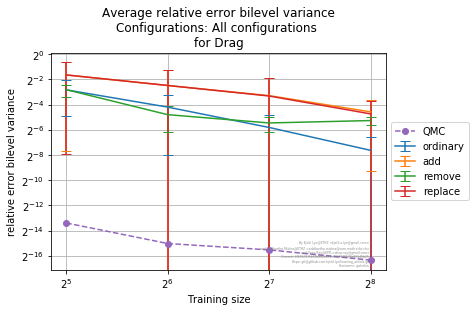

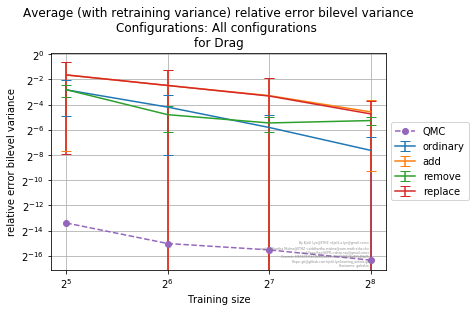

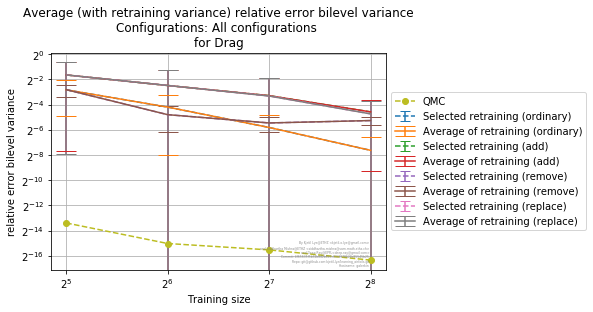

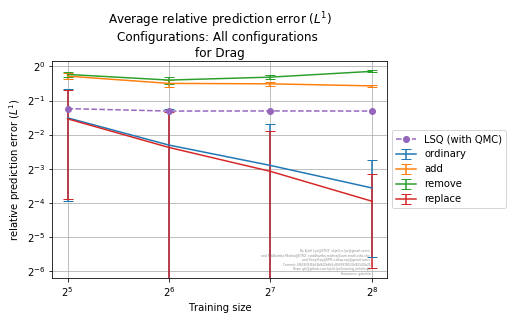

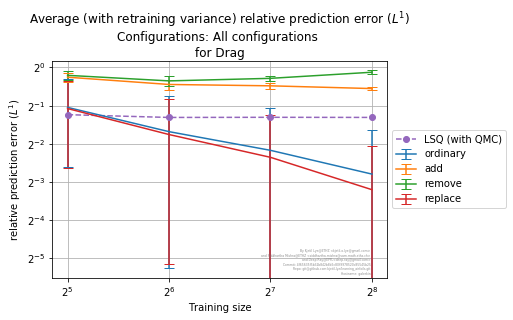

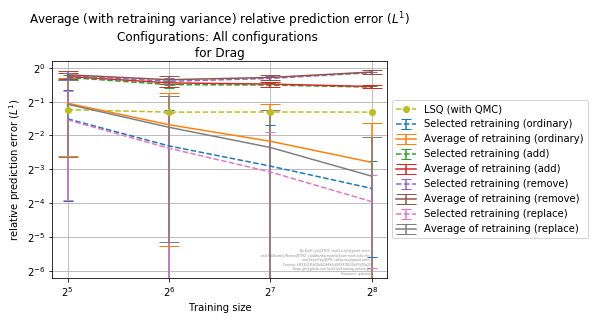

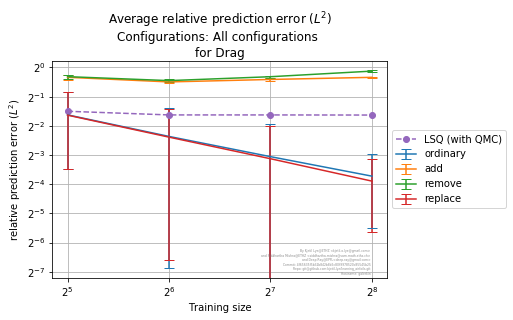

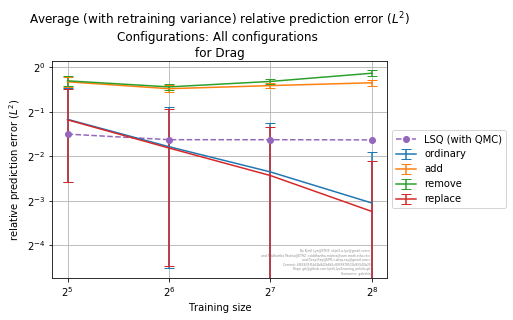

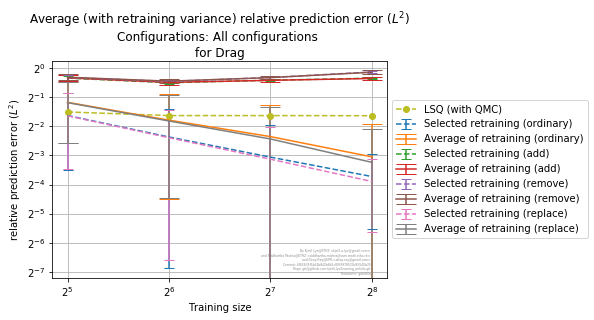

/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/usr/lib/python3.7/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)
/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, an

/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/usr/lib/python3.7/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)
/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, an

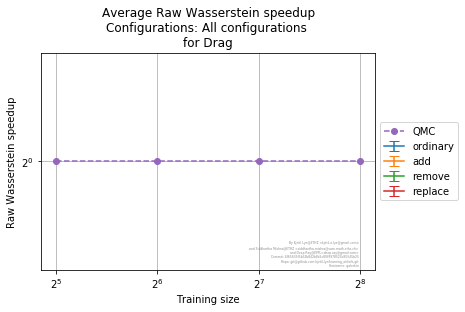

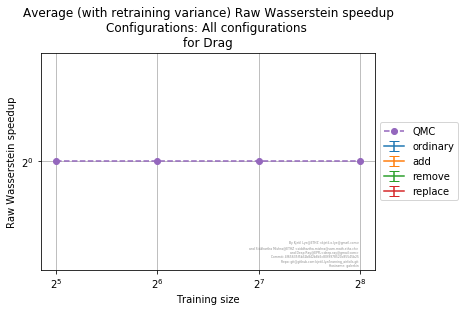

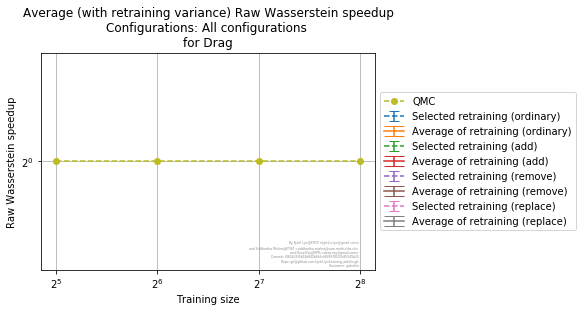

/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/usr/lib/python3.7/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)
/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/usr/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, an

KeyboardInterrupt: 

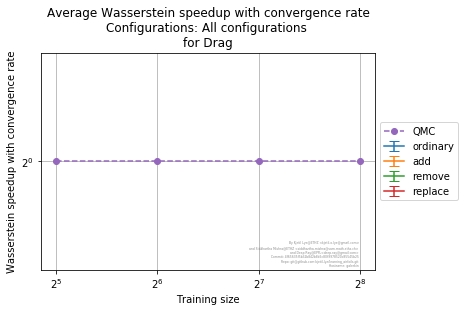

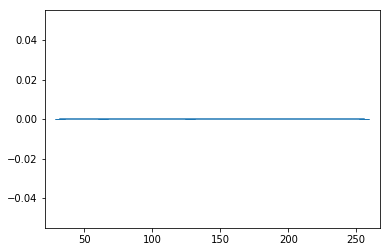

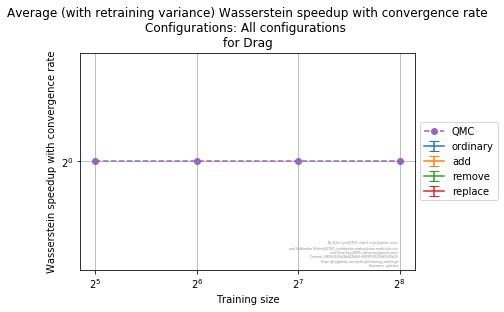

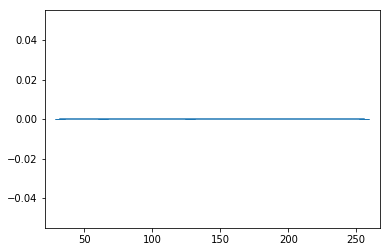

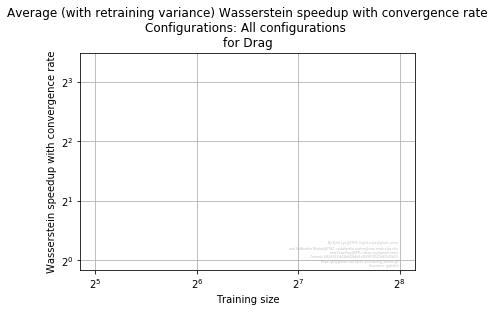

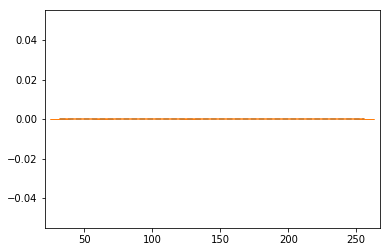

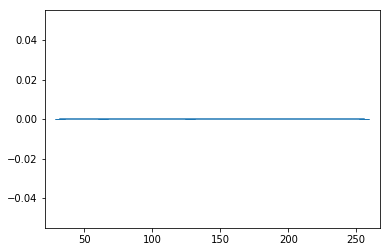

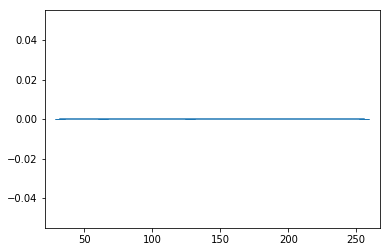

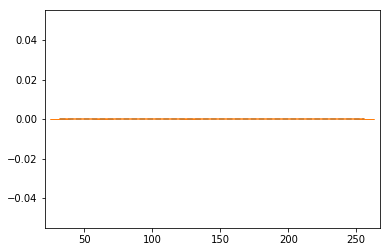

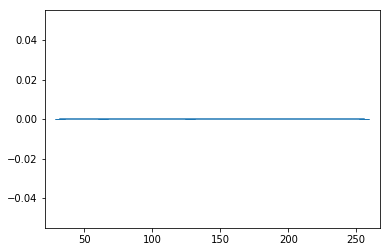

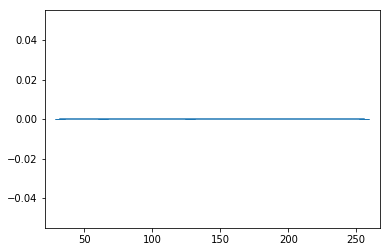

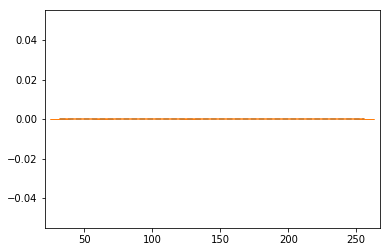

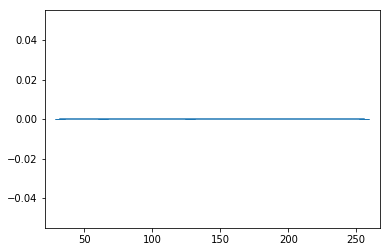

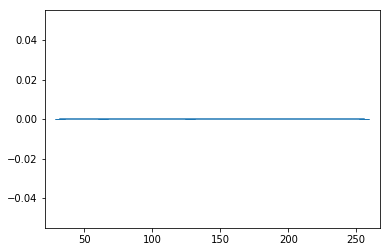

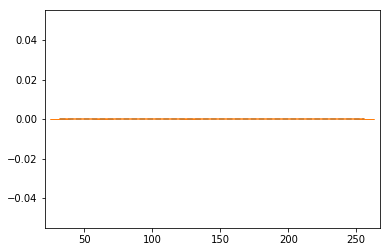

In [10]:
latex = LatexWithAllPlots()
plot_info.savePlot.callback = latex
def heading(level, content):
    
    if level == 0:
        html_code = 'h1'
        latex_code = 'section'
    elif level == 1:
        html_code = 'h2'
        latex_code = 'subsection'
        
    else:
        html_code = 'h3'
        latex_code = 'subsubsection'
    display(HTML("<{ht}>{title}<{ht}>".format(ht=html_code, title=content)))
    latex.text+= "\\{latex_code}{{{title}}}\n\n".format(latex_code=latex_code, title=content)

for functional in functionals:
    heading(0, functional)
    for filtername in filters:
        heading(1, filtername)
        for only in onlys:
            heading(2, only)
            plot_as_training_size(functional, \
                              filter_configs(data[functional], test_functions=[filters[filtername]],
                                            onlys=onlys[only]), \
                              filtername+" " + only)
            
with open('all_plots.tex') as f:
    f.write(latex.get_latex())

In [ ]:
print(data['Drag']['configurations'][0]['results']['best_network']['reference_sampling_error'].keys())
